# Шаг 5. Тестирование гипотез

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
RESULT_df_itog = pd.read_csv('RESULT_df_itog')

In [3]:
RESULT_df_itog.head()

,TRADEDATE,CLOSE_IMOEX,OPEN_IMOEX,HIGH_IMOEX,LOW_IMOEX,VALUE_IMOEX,CAPITALIZATION_IMOEX,CLOSE_MOEXMM,OPEN_MOEXMM,HIGH_MOEXMM,...,SMA_long,RSI_IMOEX,ATR_IMOEX,Price_GOLD_Lagged,Day_type_выходной,Day_type_рабочий день,DYNAMICS_IMOEX_Fall,DYNAMICS_IMOEX_Growth,ECONOMIC_GROWTH_Recession,ECONOMIC_GROWTH_Rise
0,2013-09-02,1367.53,1364.75,1373.73,1364.27,1.274407e+10,6.096417e+12,2109.53,2103.86,2120.72,...,1443.644725,100.0,22.518929,1487.36,False,True,False,True,False,True
1,2013-09-03,1373.82,1366.99,1384.18,1366.99,2.216425e+10,6.124461e+12,2102.51,2109.79,2123.56,...,1443.644725,100.0,22.518929,1487.36,False,True,False,True,False,True
2,2013-09-04,1375.66,1372.98,1376.42,1365.21,1.692969e+10,6.132675e+12,2109.74,2101.98,2112.03,...,1443.644725,100.0,22.518929,1487.36,False,True,False,True,False,True
3,2013-09-05,1422.40,1375.66,1422.40,1373.29,3.763559e+10,6.341025e+12,2161.35,2110.70,2162.06,...,1443.644725,100.0,22.518929,1487.36,False,True,False,True,False,True
4,2013-09-06,1423.40,1421.86,1448.75,1418.80,5.218912e+10,6.345500e+12,2157.45,2159.63,2199.92,...,1443.644725,100.0,22.518929,1487.36,False,True,False,True,False,True


## Тестируемые гипотезы

* 1) **H0:** Сезонность не оказывает значимое влияние на изменение цены золота.

     **H1:** Сезонность оказывает значимое влияние на повышение цены золота.

* 2) **H0:** Золото не является хеджирующим активом в условиях экономического кризиса.

     **H1:** Золото является хэджирующим активом в условиях экономического кризиса

* 3) **H0:** Курс доллара иммет одинаковую корреляцию с ценой золота с лагом в 7 дней и с ценой без лага.

     **H1:** Курс доллар рубль имеет большую корреляцию с ценой золота с лагом в 7 дней, чем с ценой золота без лага.

## Гипотеза 1

$\mu_1$ - средняя цена золота в выборке месяцев с наибольшей сезонностью для золота

$\mu_0$ - средняя цена золота в выборке месяцев с отсутствием сезонности для золота

**H0:** $\mu_1 = \mu_0$: Сезонность не оказывает значимое влияние на изменение цены золота.

**H1:** $\mu_1 > \mu_0$: Сезонность оказывает значимое влияние на повышение цены золота.

Посмотрим на данные:

In [4]:
n_higher = RESULT_df_itog[((RESULT_df_itog['month'] == 1) | (RESULT_df_itog['month'] == 2) | (RESULT_df_itog['month'] == 3) | (RESULT_df_itog['month'] == 10) | (RESULT_df_itog['month'] == 11))]['Price_GOLD'].values
n_lower = RESULT_df_itog[((RESULT_df_itog['month'] == 4) | (RESULT_df_itog['month'] == 5) | (RESULT_df_itog['month'] == 6) | (RESULT_df_itog['month'] == 7) | (RESULT_df_itog['month'] == 8) | (RESULT_df_itog['month'] == 9) | (RESULT_df_itog['month'] == 12))]['Price_GOLD'].values

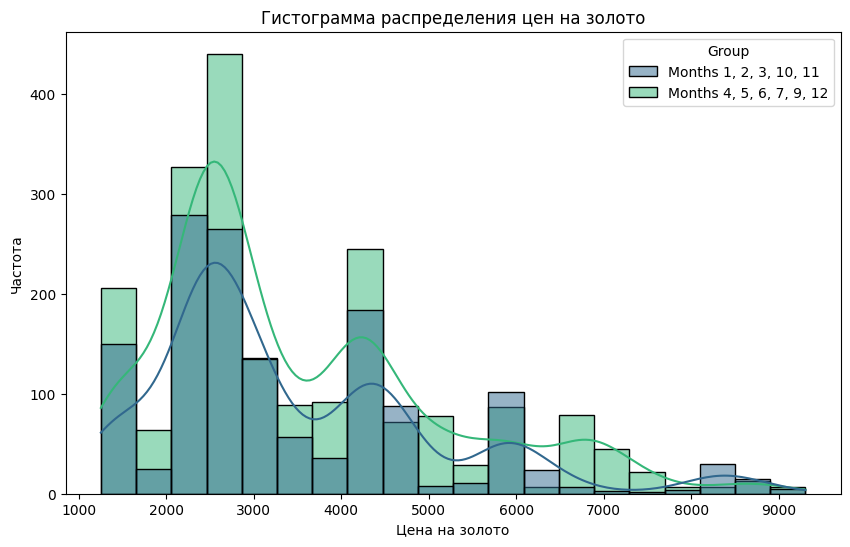

In [5]:
data_higher = pd.DataFrame({'Price_GOLD': n_higher, 'Group': 'Months 1, 2, 3, 10, 11'})
data_lower = pd.DataFrame({'Price_GOLD': n_lower, 'Group': 'Months 4, 5, 6, 7, 9, 12'})
data = pd.concat([data_higher, data_lower])

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Price_GOLD', hue='Group', bins=20, kde=True, alpha=0.5, palette='viridis')

plt.title('Гистограмма распределения цен на золото')
plt.xlabel('Цена на золото')
plt.ylabel('Частота')

plt.show()

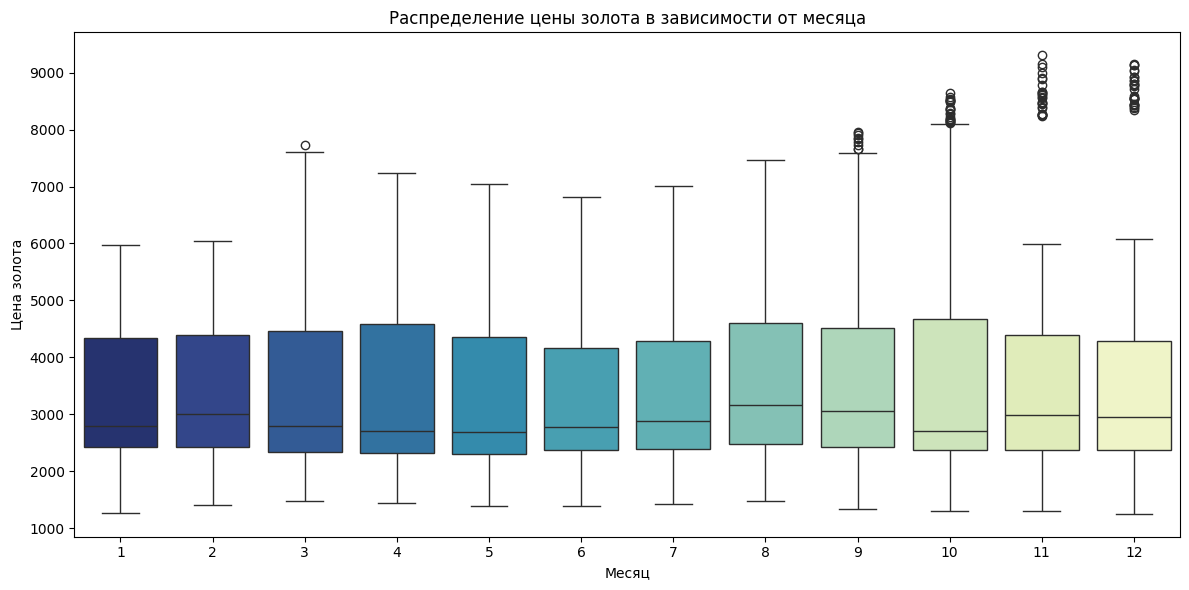

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Price_GOLD', data=RESULT_df_itog, palette = 'YlGnBu_r')
plt.xlabel('Месяц')
plt.ylabel('Цена золота')
plt.title('Распределение цены золота в зависимости от месяца')
plt.tight_layout()
plt.show()

**Вывод:** Видно, что цены на золото не распределены нормально, распределение несимметрично, также присутствуют выбросы, поэтому использование z test (для нормального распределения) или t test (для распределения Стьюдента) может показать некорректные результаты, так как нарушаются их предпосылки. Поэтому мы будем использовать бутстреп для несимметричного распределения, предпосылка которого ($ n \to \infty$) выполнена.

In [7]:
# функция реализации бутстрепа
def get_bootstrap(n_higher, n_lower, n=10000, alpha=0.05):
    teor_diff = np.mean(n_higher) - np.mean(n_lower)
    diffs = []
    for _ in range(n):
        boot_higher = np.random.choice(n_higher, size=len(n_higher), replace=True) # выборки с повторениями для h_higher
        boot_lower = np.random.choice(n_lower, size=len(n_lower), replace=True) # выборки с повторениями для h_lower
        diffs.append(np.mean(boot_higher) - np.mean(boot_lower))
    p_value = np.sum(diffs >= teor_diff) / n
    left = np.quantile(diffs, alpha / 2)
    right = np.quantile(diffs, 1 - alpha / 2)
    ci = (left, right)
    return p_value, diffs, teor_diff, ci

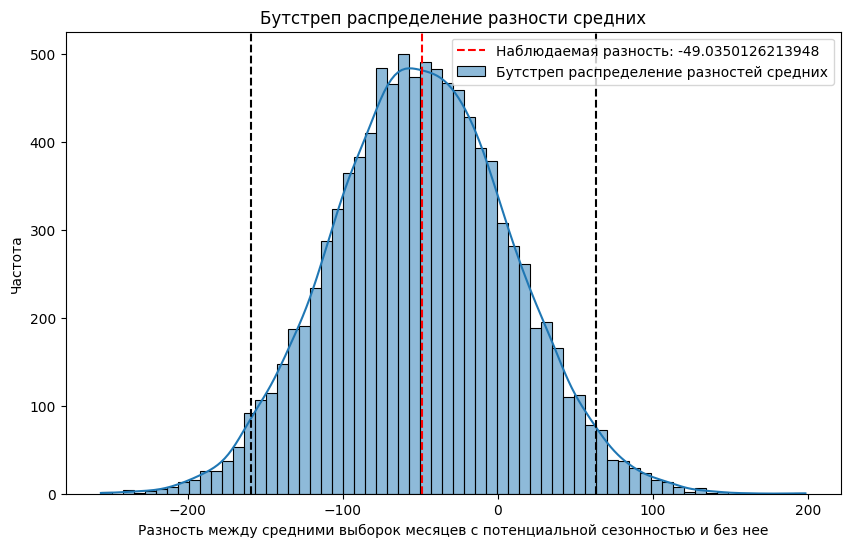

p_value = 
0.4972
Наблюдаемое значение = 
-49.0350126213948
Левая граница доверительного интервала = 
-159.25
Правая граница доверительного интервала = 
63.49


In [8]:
p_value, diffs, teor_diff, ci = get_bootstrap(n_higher, n_lower)
plt.figure(figsize=(10, 6))
sns.histplot(diffs, kde=True, label='Бутстреп распределение разностей средних')
plt.axvline(teor_diff, color='red', linestyle='--', label=f'Наблюдаемая разность: {teor_diff}')
plt.axvline(ci[0], color='black', linestyle='--')
plt.axvline(ci[1], color='black', linestyle='--')
plt.xlabel('Разность между средними выборок месяцев с потенциальной сезонностью и без нее')
plt.ylabel('Частота')
plt.title('Бутстреп распределение разности средних')
plt.legend()
plt.show()

print(f'p_value = \n{p_value}')
print(f"Наблюдаемое значение = \n{teor_diff}")
print(f'Левая граница доверительного интервала = \n{round(ci[0], 2)}')
print(f'Правая граница доверительного интервала = \n{round(ci[1], 2)}')

**Вывод:** Так как p value получился больше уровня значимости альфа, **гипотеза H0 при уровне значимости = 5% не отвергается**. То есть, сезонность не оказывает значимое влияние на изменение цены золота. Это может быть связано с тем, что выраженность сезонности в абсолютных значениях невелика, либо апроксимированные данные за несколько лет сглаживают её, поэтому статистических доказательств для опровержения отсутствия сезонности нет.

## Гипотеза 2

$\mu_1$ - средняя цена золота в период экономической рецессии

$\mu_0$ - средняя цена золота в период экономической стабильности или роста

**H0:** $\mu_1 = \mu_0$: Золото не является хеджирующим активом в условиях экономического кризиса

**H1:** $\mu_1 > \mu_0$: Золото является хэджирующим активом в условиях экономического кризиса

In [9]:
sample_higher = RESULT_df_itog[(RESULT_df_itog['ECONOMIC_GROWTH_Recession'] == True)]['Price_GOLD'].values
sample_lower = RESULT_df_itog[(RESULT_df_itog['ECONOMIC_GROWTH_Recession'] == True)]['Price_GOLD'].values

In [10]:
p_value, diffs, teor_diff, ci = get_bootstrap(sample_higher, sample_lower)

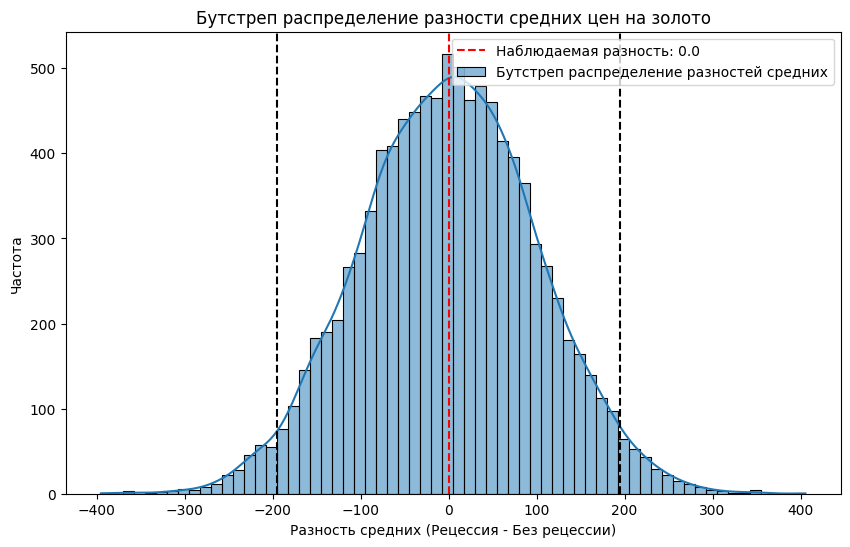

p_value = 
0.504
Наблюдаемое значение = 
0.0
Левая граница доверительного интервала = 
-194.74
Правая граница доверительного интервала = 
194.79


In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(diffs, kde=True, label='Бутстреп распределение разностей средних')
plt.axvline(teor_diff, color='red', linestyle='--', label=f'Наблюдаемая разность: {teor_diff}')
plt.axvline(ci[0], color='black', linestyle='--')
plt.axvline(ci[1], color='black', linestyle='--')
plt.xlabel('Разность средних (Рецессия - Без рецессии)')
plt.ylabel('Частота')
plt.title('Бутстреп распределение разности средних цен на золото')
plt.legend()
plt.show()

print(f'p_value = \n{p_value}')
print(f"Наблюдаемое значение = \n{teor_diff}")
print(f'Левая граница доверительного интервала = \n{round(ci[0], 2)}')
print(f'Правая граница доверительного интервала = \n{round(ci[1], 2)}')

**Вывод:** Так как p value получился больше уровня, **гипотеза H0 при уровне значимости = 5% не отвергается**. То есть на наших данных получилось, что в условиях золото не является хэджирующим активом в период экономического спада. Возможная интерпретация такого результата и его различий относительно финансовой теории состоит в различиях определения рецессии в этом исследовании и на практике.

## Гипотеза 3

 **H0:** Курс доллара имеет одинаковую корреляцию с ценой золота с лагом в 7 дней и с ценой без лага.

 **H1:** Курс доллар рубль имеет большую корреляцию с ценой золота с лагом в 7 дней, чем с ценой золота без лага.

In [12]:
corr_GOLD_Lag = RESULT_df_itog['USD_RUB'].corr(RESULT_df_itog['Price_GOLD_Lagged'])
print(round(corr_GOLD_Lag, 2))

0.9


In [13]:
corr_GOLD_Cur = RESULT_df_itog['USD_RUB'].corr(RESULT_df_itog['Price_GOLD'])
print(round(corr_GOLD_Cur,2))

0.9


**Вывод:** Так как корреляция валютного курса с ценой золота с лагом в 7 дней равна корреляции с ценой доллара в текущем времени, **гипотеза H0 не отвергается**. То есть, корреляция между валютным курсом и ценой золота в текущий момент и с лагом в 7 дней неизменна. Это может быть связано с тем, что лаг слишком маленький или большой по времени, поэтому в дальнейшем можно анализировать корреляцию с другими значениями лага цен на золото.